In [2]:
import pandas as pd
import regex as re

In [3]:
data1 = pd.read_fwf('local-exp-gl2-data.txt', skiprows=[1])
data2 = pd.read_fwf('local-exp-gl6-data.txt', skiprows=[1])
data = pd.concat([data1, data2])
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,43249,dpp-local-nc32_gl6-10.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,None
134,43252,daa-local-nc16_gl6-9.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,None
135,43255,daa-local-nc2_gl6-2.cfg,gl2_gl4,assigned,CANCELLED+,None,2023-11-30T16:14:15,0,NaN,NaN,NaN,NaN,00:00:00,2,None
136,43258,daa-local-nc2_gl6-1.cfg,gl2_gl4,assigned,CANCELLED+,None,2023-11-30T16:14:15,0,NaN,NaN,NaN,NaN,00:00:00,2,None


In [4]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds


data = data[data.State == 'COMPLETED']
data.JobName = data.JobName.replace('batch', method='ffill')
data = data.dropna(subset=['ConsumedEnergy'])
data = data.drop('Unnamed: 3', axis=1)
data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data[['Workflow', 'mode', 'ncores', 'node', 'trial']] = data.JobName.str.extract(
    r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
data.ncores = data.ncores.astype(int)
data.trial = data.trial.astype(int)

for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
    data[column] = data[column].apply(convert_to_numeric)
    data[f"{column}K"] = data[column] / 1000
    data[f"{column}M"] = data[column] / 1000000

data['ElapsedSeconds'] = data.Elapsed.apply(convert_elapsed_time)
data['ElapsedMinutes'] = data.ElapsedSeconds / 60
data['ElapsedHours'] = data.ElapsedMinutes / 60

data = data.sort_values(by=['ncores', 'Workflow'])
data

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_47544\2895311873.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.JobName = data.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveRSSM,AveDiskReadK,AveDiskReadM,AveDiskWriteK,AveDiskWriteM,AveVMSizeK,AveVMSizeM,ElapsedSeconds,ElapsedMinutes,ElapsedHours
8,42826.batch,daa-local-nc4_gl2-5.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-30T22:09:05,2023-12-01T14:41:24,3040000.0,1.296320e+09,8.838186e+10,...,1296.320,88381860.0,88381.86,12728740.0,12728.74,19389280.0,19389.280,59539,992.316667,16.538611
9,42832.batch,daa-local-nc4_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-01T14:46:26,2023-12-02T07:20:32,3040000.0,1.192524e+09,8.838420e+10,...,1192.524,88384200.0,88384.20,12731990.0,12731.99,19387324.0,19387.324,59646,994.100000,16.568333
13,42853.batch,daa-local-nc4_gl2-6.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-02T15:29:44,2023-12-03T07:57:43,3030000.0,1.181660e+09,8.838194e+10,...,1181.660,88381940.0,88381.94,12728740.0,12728.74,19389224.0,19389.224,59279,987.983333,16.466389
16,42871.batch,daa-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-03T10:13:21,2023-12-04T02:39:18,3030000.0,1.164340e+09,8.838404e+10,...,1164.340,88384040.0,88384.04,12731830.0,12731.83,19388960.0,19388.960,59157,985.950000,16.432500
17,42874.batch,daa-local-nc4_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-04T02:44:22,2023-12-04T19:10:36,3030000.0,1.185192e+09,8.838194e+10,...,1185.192,88381940.0,88381.94,12728740.0,12728.74,19388384.0,19388.384,59174,986.233333,16.437222
30,43006.batch,daa-local-nc4_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-11-30T21:17:36,2023-12-01T14:36:21,7580000.0,1.449556e+09,8.837861e+10,...,1449.556,88378610.0,88378.61,12751500.0,12751.50,27512980.0,27512.980,62325,1038.750000,17.312500
44,43066.batch,daa-local-nc4_gl6-10.cfg,gl2_gl4,gl6,COMPLETED,2023-12-02T19:13:37,2023-12-03T12:28:30,7570000.0,1.460336e+09,8.835440e+10,...,1460.336,88354400.0,88354.40,12748260.0,12748.26,27518776.0,27518.776,62093,1034.883333,17.248056
46,43072.batch,daa-local-nc4_gl6-2.cfg,gl2_gl4,gl6,COMPLETED,2023-12-03T17:15:58,2023-12-04T10:29:22,7520000.0,1.459092e+09,8.835903e+10,...,1459.092,88359030.0,88359.03,12751480.0,12751.48,27514860.0,27514.860,62004,1033.400000,17.223333
47,43075.batch,daa-local-nc4_gl6-7.cfg,gl2_gl4,gl6,COMPLETED,2023-12-04T10:34:23,2023-12-05T03:47:07,7540000.0,1.464448e+09,8.835636e+10,...,1464.448,88356360.0,88356.36,12751100.0,12751.10,27512264.0,27512.264,61964,1032.733333,17.212222
48,43078.batch,daa-local-nc4_gl6-1.cfg,gl2_gl4,gl6,COMPLETED,2023-12-05T03:52:11,2023-12-05T21:14:34,7550000.0,1.461064e+09,8.835436e+10,...,1461.064,88354360.0,88354.36,12749160.0,12749.16,27515356.0,27515.356,62543,1042.383333,17.373056


In [5]:
# All collected data
data.groupby(['Workflow', 'mode', 'ncores', 'node']).size().reset_index(name='count').sort_values(
    by=['Workflow', "node", "ncores"])

,Workflow,mode,ncores,node,count
0,daa,local,4,gl2,5
1,daa,local,4,gl6,5
2,daa,local,8,gl2,5
3,daa,local,8,gl6,2
4,daa,local,16,gl6,3
5,daa,local,32,gl6,6
6,dpp,local,4,gl2,7
7,dpp,local,4,gl6,3
8,dpp,local,8,gl2,4
9,dpp,local,8,gl6,5


In [6]:
mask = (data.groupby(['Workflow', 'mode', 'ncores', 'node']).size()).reset_index(name='count')
mask['count_threshold'] = mask['count'] > 1
mask = mask[mask.count_threshold]
mask

,Workflow,mode,ncores,node,count,count_threshold
0,daa,local,4,gl2,5,True
1,daa,local,4,gl6,5,True
2,daa,local,8,gl2,5,True
3,daa,local,8,gl6,2,True
4,daa,local,16,gl6,3,True
5,daa,local,32,gl6,6,True
6,dpp,local,4,gl2,7,True
7,dpp,local,4,gl6,3,True
8,dpp,local,8,gl2,4,True
9,dpp,local,8,gl6,5,True


In [7]:
mask.drop(['count', 'count_threshold'], axis=1, inplace=True)
data = data.merge(mask, on=['Workflow', 'mode', 'ncores', 'node'], how='inner')
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveRSSM,AveDiskReadK,AveDiskReadM,AveDiskWriteK,AveDiskWriteM,AveVMSizeK,AveVMSizeM,ElapsedSeconds,ElapsedMinutes,ElapsedHours
0,42826.batch,daa-local-nc4_gl2-5.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-30T22:09:05,2023-12-01T14:41:24,3040000.0,1.296320e+09,8.838186e+10,...,1296.320,88381860.0,88381.86,12728740.0,12728.74,19389280.0,19389.280,59539,992.316667,16.538611
1,42832.batch,daa-local-nc4_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-01T14:46:26,2023-12-02T07:20:32,3040000.0,1.192524e+09,8.838420e+10,...,1192.524,88384200.0,88384.20,12731990.0,12731.99,19387324.0,19387.324,59646,994.100000,16.568333
2,42853.batch,daa-local-nc4_gl2-6.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-02T15:29:44,2023-12-03T07:57:43,3030000.0,1.181660e+09,8.838194e+10,...,1181.660,88381940.0,88381.94,12728740.0,12728.74,19389224.0,19389.224,59279,987.983333,16.466389
3,42871.batch,daa-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-03T10:13:21,2023-12-04T02:39:18,3030000.0,1.164340e+09,8.838404e+10,...,1164.340,88384040.0,88384.04,12731830.0,12731.83,19388960.0,19388.960,59157,985.950000,16.432500
4,42874.batch,daa-local-nc4_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-04T02:44:22,2023-12-04T19:10:36,3030000.0,1.185192e+09,8.838194e+10,...,1185.192,88381940.0,88381.94,12728740.0,12728.74,19388384.0,19388.384,59174,986.233333,16.437222
5,43006.batch,daa-local-nc4_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-11-30T21:17:36,2023-12-01T14:36:21,7580000.0,1.449556e+09,8.837861e+10,...,1449.556,88378610.0,88378.61,12751500.0,12751.50,27512980.0,27512.980,62325,1038.750000,17.312500
6,43066.batch,daa-local-nc4_gl6-10.cfg,gl2_gl4,gl6,COMPLETED,2023-12-02T19:13:37,2023-12-03T12:28:30,7570000.0,1.460336e+09,8.835440e+10,...,1460.336,88354400.0,88354.40,12748260.0,12748.26,27518776.0,27518.776,62093,1034.883333,17.248056
7,43072.batch,daa-local-nc4_gl6-2.cfg,gl2_gl4,gl6,COMPLETED,2023-12-03T17:15:58,2023-12-04T10:29:22,7520000.0,1.459092e+09,8.835903e+10,...,1459.092,88359030.0,88359.03,12751480.0,12751.48,27514860.0,27514.860,62004,1033.400000,17.223333
8,43075.batch,daa-local-nc4_gl6-7.cfg,gl2_gl4,gl6,COMPLETED,2023-12-04T10:34:23,2023-12-05T03:47:07,7540000.0,1.464448e+09,8.835636e+10,...,1464.448,88356360.0,88356.36,12751100.0,12751.10,27512264.0,27512.264,61964,1032.733333,17.212222
9,43078.batch,daa-local-nc4_gl6-1.cfg,gl2_gl4,gl6,COMPLETED,2023-12-05T03:52:11,2023-12-05T21:14:34,7550000.0,1.461064e+09,8.835436e+10,...,1461.064,88354360.0,88354.36,12749160.0,12749.16,27515356.0,27515.356,62543,1042.383333,17.373056


In [16]:
import matplotlib.pyplot as plt

jobs_per_day=7.2, left_jobs=69, left_days=9.583333333333334


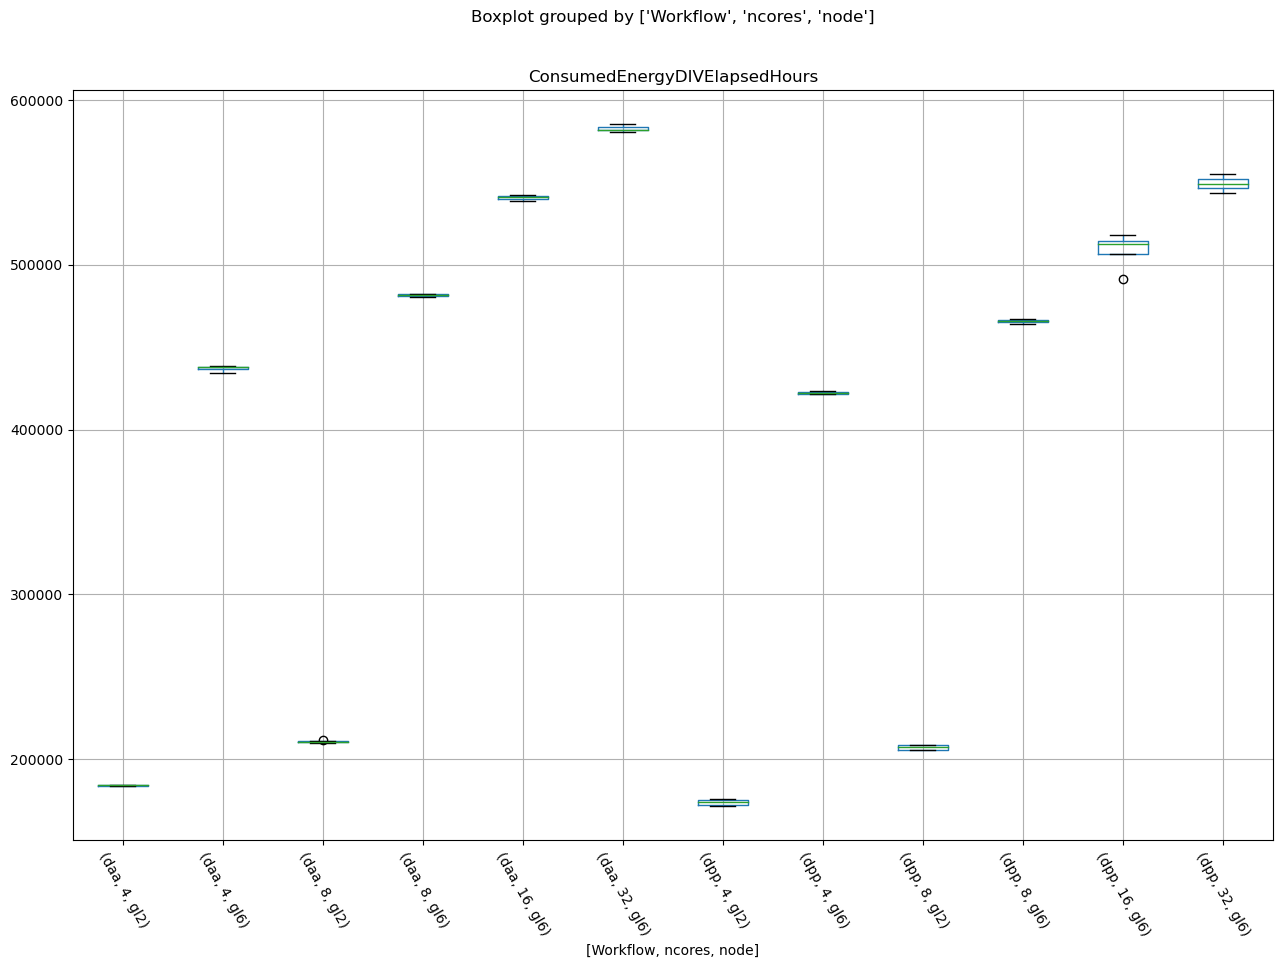

In [9]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
plt.show()
# save
fig.savefig('boxplot.png')


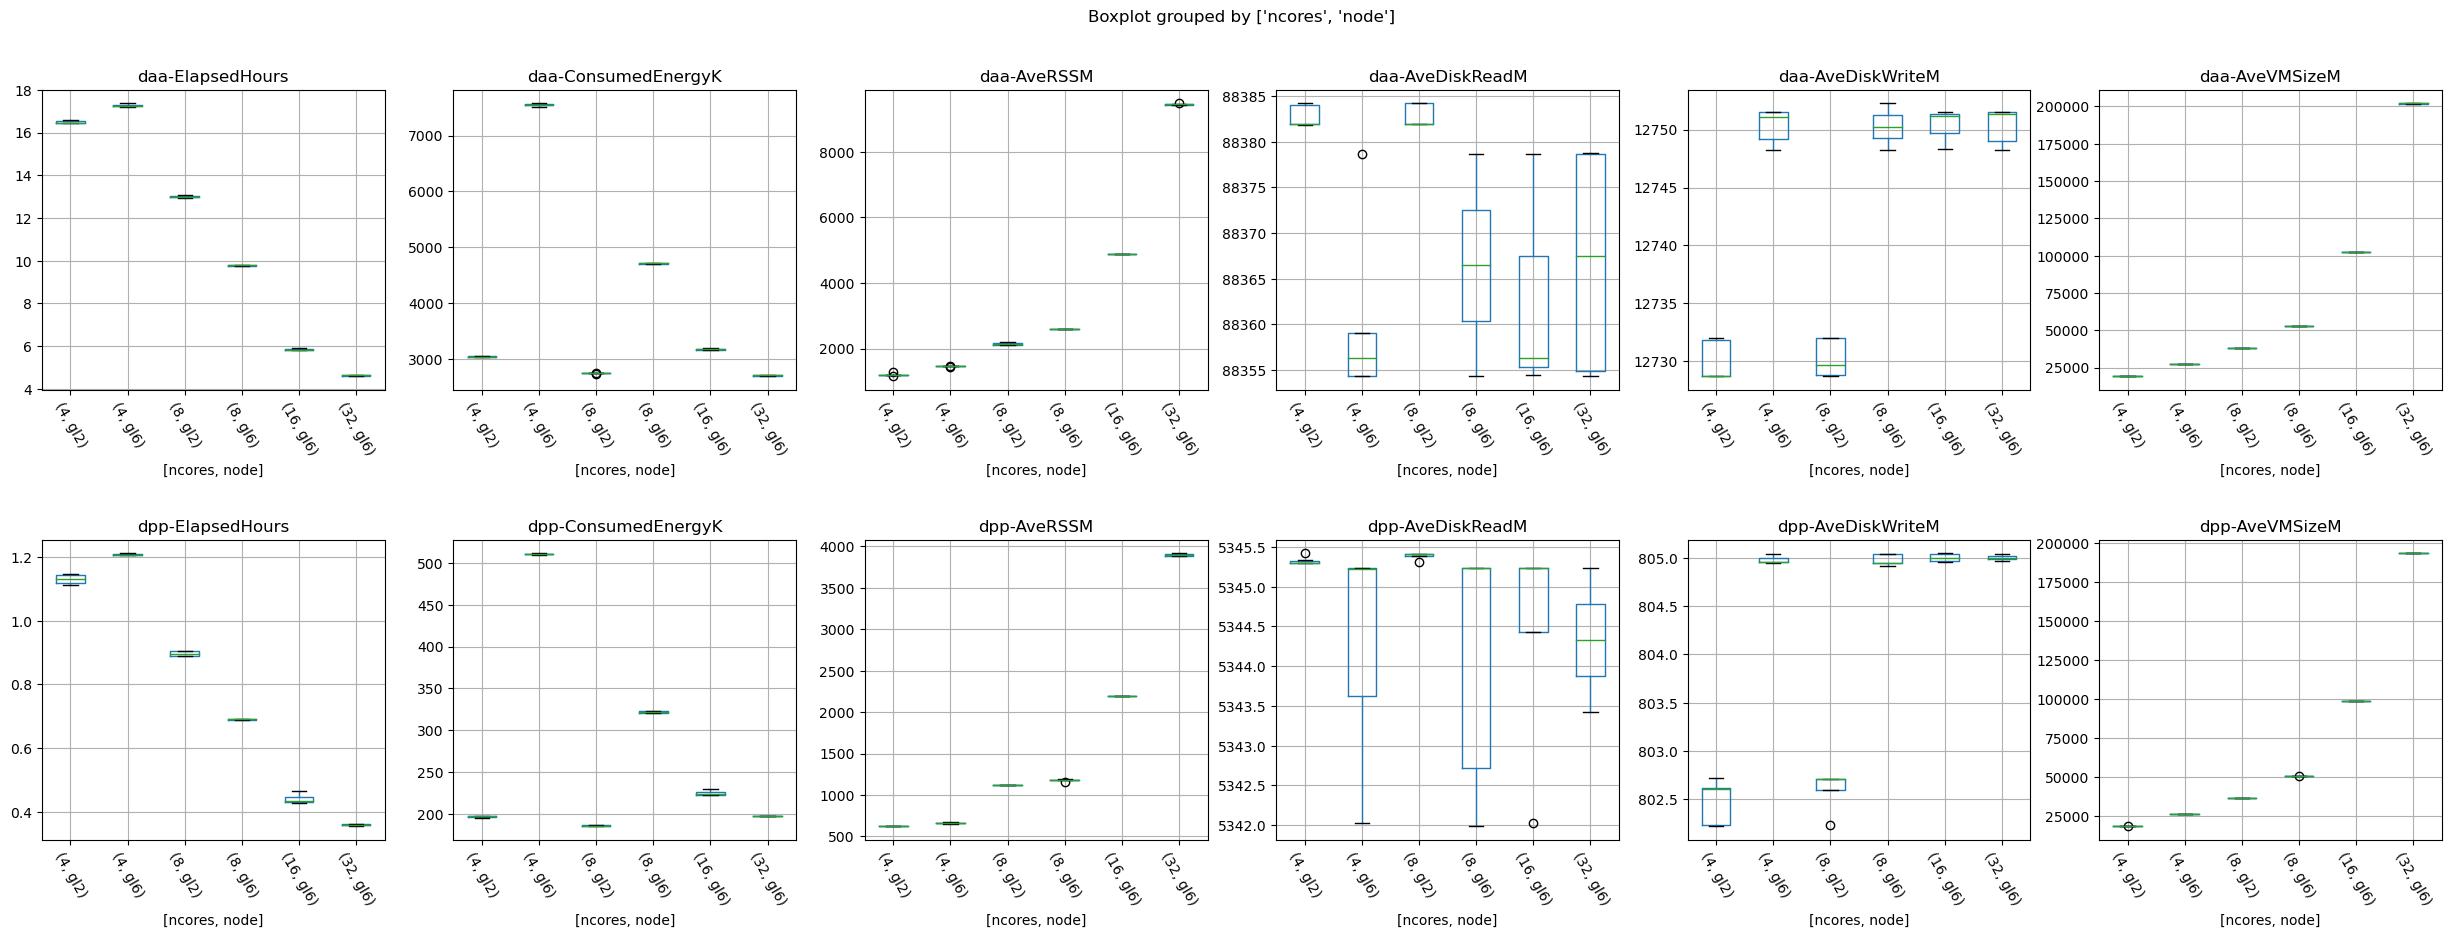

In [46]:
# draw two plots based on workflow containing multiple boxplots with data distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(40, 10))
for j, workflow in enumerate(data.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data[data.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'], ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        # next to every boxplot box show data distribution

fig.savefig('boxplot-overview-by-workflows.png')

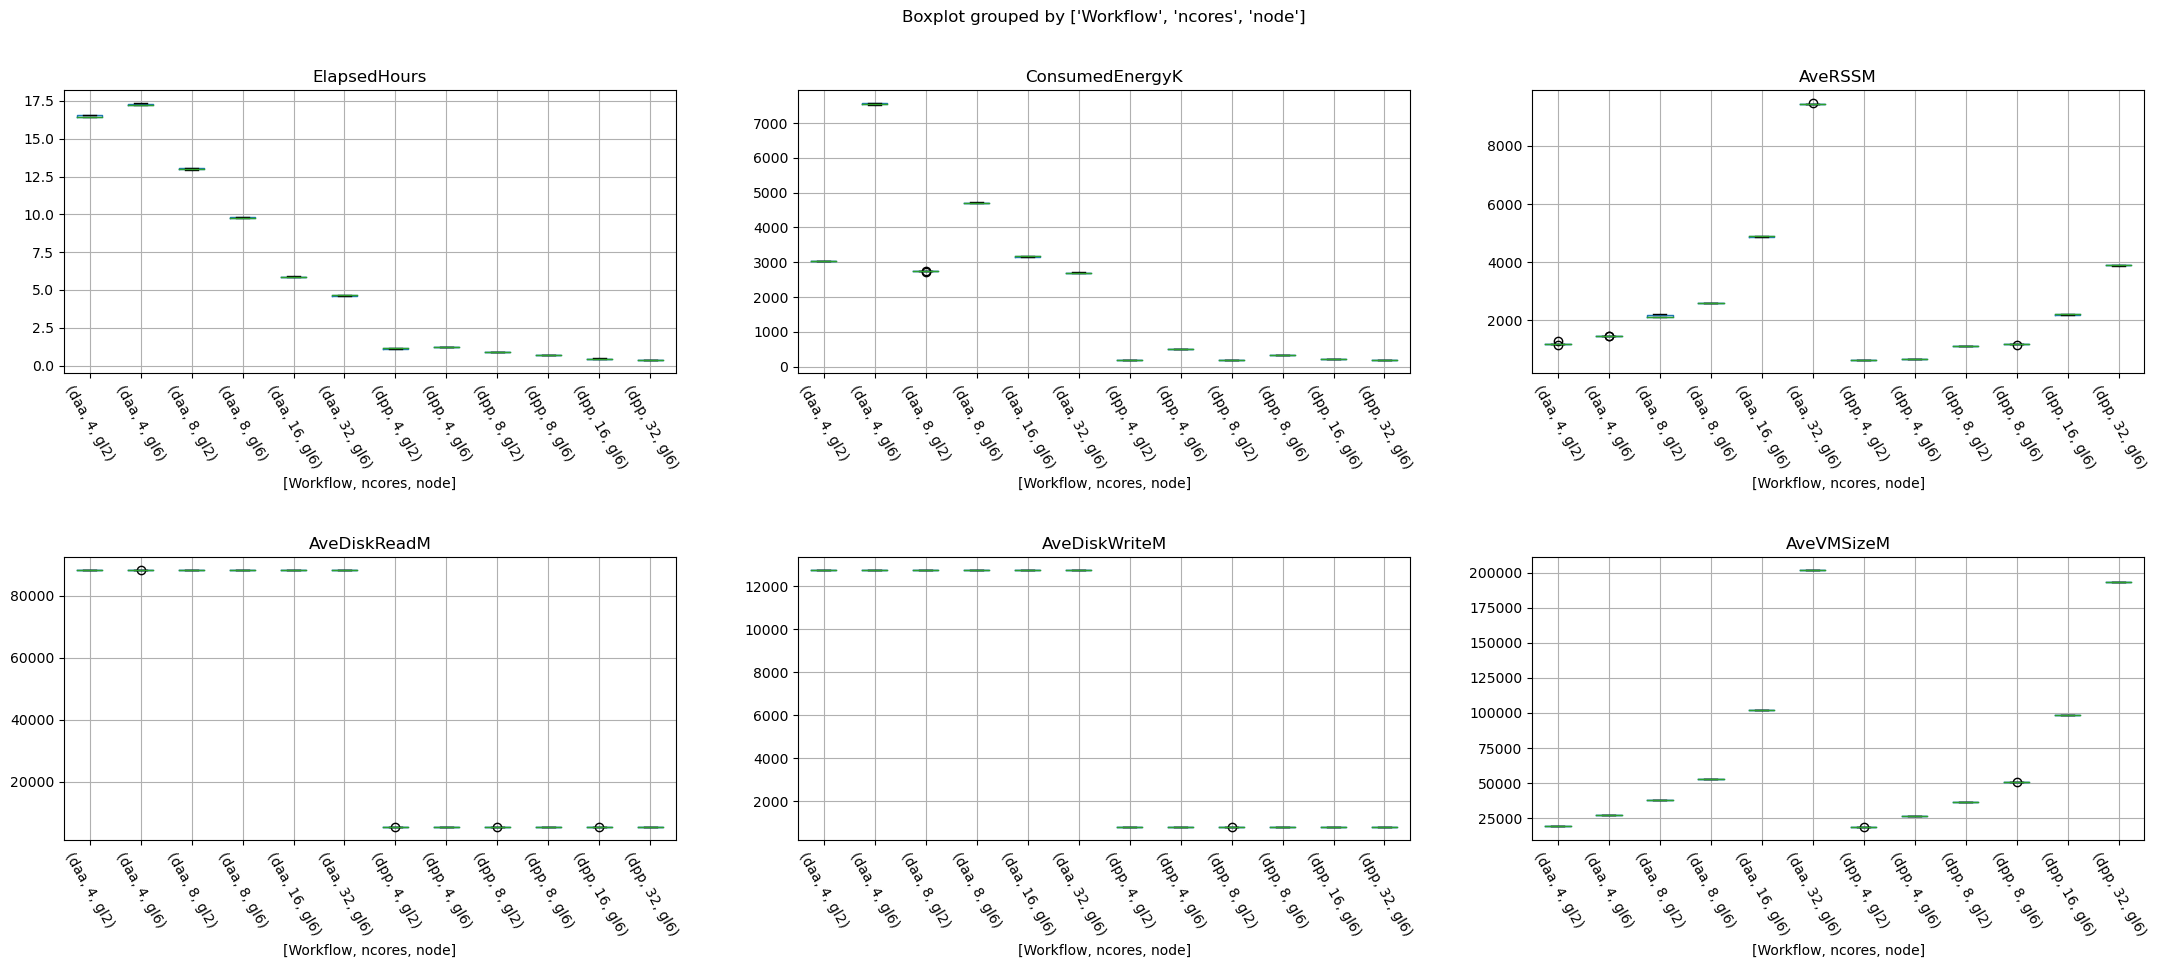

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(40, 20))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)

fig.savefig('boxplot-overview.png')